# FRiP

Plots for single-cell fraction of reads in peak sets (FRiP). 

For Fig1 subfigure, would plot the FRiP in iPSC peaks and Fibroblast peaks.
For Fig2 subfigure, plot FRiP in peaks with O,S,K motifs.

Inputs:

1. `metadata.tsv` with UMAP/densMAP coordinates and total fragments/insertions.
2. Single-cell counts matrix derived from snapATAC with corresponding peaks.
3. Peak sets:
      - Fig 1: with Fibroblast and iPSC peaks.
      - Fig 2: with O,S,K motifs

In [1]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)
library(rtracklayer)
library(scattermore)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

## Loading Inputs

### MetaData

In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 62599     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,-1.8037916,-9.507773,1,D0_AAACACGCTAGTACGG
D0_AAACACGCTCTTCAAG,AAACACGCTCTTCAAG,D0,0.7074551,-9.406457,1,D0_AAACACGCTCTTCAAG
D0_AAACACGCTGATCCAT,AAACACGCTGATCCAT,D0,-2.9559933,-7.641148,1,D0_AAACACGCTGATCCAT
D0_AAACCCTGACCGCTAG,AAACCCTGACCGCTAG,D0,-3.6119107,-8.443144,1,D0_AAACCCTGACCGCTAG
D0_AAACCCTGATTGCAGT,AAACCCTGATTGCAGT,D0,0.5002119,-8.759449,3,D0_AAACCCTGATTGCAGT


### Insertions Count Matrix + Regions

In [4]:
pmat = readMM("../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  62599 530910

In [5]:
peak_regions = read.table("../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/peaks.bed")
names(peak_regions) = c("chr", "bp1", "bp2")
peak_regions$site_name <- paste(peak_regions$chr, peak_regions$bp1, peak_regions$bp2, sep="_")
row.names(peak_regions) <- peak_regions$site_name
dim(peak_regions)
head(peak_regions)

[1] 530910      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr17_32960817_32961317,chr17,32960817,32961317,chr17_32960817_32961317
chr17_75764252_75764752,chr17,75764252,75764752,chr17_75764252_75764752
chr17_1473114_1473614,chr17,1473114,1473614,chr17_1473114_1473614
chr17_4206897_4207397,chr17,4206897,4207397,chr17_4206897_4207397
chr17_423409_423909,chr17,423409,423909,chr17_423409_423909
chr17_1964634_1965134,chr17,1964634,1965134,chr17_1964634_1965134


In [6]:
peak_regions_gr =  GRanges(sub("_", "-", sub("_", ":", rownames(peak_regions))))

In [7]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836"))+500, peak_regions_gr))])

[1] 1768

In [8]:
pmatRowSums = Matrix::rowSums(pmat)

In [9]:
# these values should correlate well (reads in peaks vs total reads)
# this data is present in the metaData in 20200122_SnapATAC session
# cor(pmatRowSums, metaData$total_insertions, method='spearman')

In [10]:
# hist(pmatRowSums/metaData$total_insertions)

## Plotting Function

In [11]:
get_frip_plot <- function(reads_in_peaks, title, peak_subset, upper_perc=0.99) {
    plot_df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2,
                    percent_reads=reads_in_peaks)
    # shuffle so days don't overlap
    plot_df = plot_df[sample(dim(plot_df)[1]), ]


    frip_plot <- ggplot(plot_df) +
        geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
        scale_color_viridis_c(limits=c(quantile(reads_in_peaks, 0.1), 
                                   quantile(reads_in_peaks, upper_perc)), 
                          oob=squish,
                              name="Normalized\nInsertions", 
                              option = "B") +
        ggtitle(sprintf("%s (%d Mbp)",  
                        title,
                        as.integer(sum(width(peak_subset))/1e6))) + 
        theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()
    
    frip_plot
}

In [43]:
get_frip_plot_small <- function(reads_in_peaks, title, peak_subset, upper_perc=0.99) {
    plot_df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2,
                    percent_reads=reads_in_peaks)
    # shuffle so days don't overlap
    plot_df = plot_df[sample(dim(plot_df)[1], 20000), ]


    frip_plot <- ggplot(plot_df) +
        geom_scattermore(pointsize=3, aes(x=umap1 , y=umap2, col=percent_reads), pixels=c(1000,1000)) +
        scale_color_viridis_c(limits=c(quantile(reads_in_peaks, 0.1), 
                                   quantile(reads_in_peaks, upper_perc)), 
                          oob=squish,
                              name="Normalized\nInsertions", 
                              option = "D") +
        ggtitle(title) + 
        theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              legend.title = element_blank(),
              legend.text = element_blank(), # no numbers
              legend.background = element_blank(), # strip whitespace around colorbar
              legend.key.size = unit(0.15, "inches"),
              legend.position = c(0.08, 0.16), 
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()
    
    frip_plot
}

## Fig 1

### Peak Sets

In [14]:
fibroblast_peaks = import("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx1/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz")
fibroblast_peaks

GRanges object with 216895 ranges and 6 metadata columns:
           seqnames              ranges strand |        name     score
              <Rle>           <IRanges>  <Rle> | <character> <numeric>
       [1]    chr17   43251452-43252071      * |        <NA>      1000
       [2]     chr1   16612525-16614010      * |        <NA>      1000
       [3]    chr16   30193194-30194538      * |        <NA>      1000
       [4]    chr21     8445735-8447098      * |        <NA>      1000
       [5]     chr1 236097027-236097479      * |        <NA>      1000
       ...      ...                 ...    ... .         ...       ...
  [216891]    chr14   68621375-68622331      * |        <NA>      1000
  [216892]    chr10 133236506-133238119      * |        <NA>       889
  [216893]     chrX   20061512-20062450      * |        <NA>      1000
  [216894]     chr1     7993849-7994788      * |        <NA>      1000
  [216895]     chr2   47058239-47058939      * |        <NA>      1000
           signalVa

In [15]:
iPSC_peaks = import("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx8/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz")
iPSC_peaks

GRanges object with 212099 ranges and 6 metadata columns:
           seqnames              ranges strand |        name     score
              <Rle>           <IRanges>  <Rle> | <character> <numeric>
       [1]    chr17   43251452-43252059      * |        <NA>      1000
       [2]    chr13 109424065-109424402      * |        <NA>      1000
       [3]     chr1       633876-634897      * |        <NA>      1000
       [4]     chr1 236097032-236097477      * |        <NA>      1000
       [5]     chr1   16613208-16614034      * |        <NA>      1000
       ...      ...                 ...    ... .         ...       ...
  [212095]     chr1 171715619-171716457      * |        <NA>      1000
  [212096]     chr1 171396714-171397491      * |        <NA>      1000
  [212097]     chr1 151036254-151037708      * |        <NA>       677
  [212098]     chr1 112221347-112222256      * |        <NA>      1000
  [212099]     chr1 102174152-102174818      * |        <NA>      1000
           signalVa

## Plotting

### Fibroblast Peak Set

In [16]:
peak_intersect_fibr = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, fibroblast_peaks)))]
peak_intersect_fibr

GRanges object with 148870 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 75764252-75764752      *
       [2]    chr17   8056095-8056595      *
       [3]    chr17   7477338-7477838      *
       [4]    chr17 62423646-62424146      *
       [5]    chr17   2359390-2359890      *
       ...      ...               ...    ...
  [148866]     chrY 56677981-56678481      *
  [148867]     chrY 15593692-15594192      *
  [148868]     chrY   2907218-2907718      *
  [148869]     chrY 15536260-15536760      *
  [148870]     chrY   7936006-7936506      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [38]:
# dividing by total insertions doesn't give a clean signal for iPSC peaks, D12/14 have overall low fraction of reads in peaks

# reads_in_fibr_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, fibroblast_peaks)))])/metaData$total_insertions
reads_in_fibr_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, fibroblast_peaks)))])/pmatRowSums

In [39]:
min(reads_in_fibr_peaks)
median(reads_in_fibr_peaks)
max(reads_in_fibr_peaks)

[1] 0.332334

[1] 0.6724431

[1] 0.9443878

In [40]:
# cor(reads_in_fibr_peaks, metaData$total_insertions, method='spearman')

In [44]:
fibr_frip = get_frip_plot_small(reads_in_fibr_peaks, "Insertions in Fibroblast Peaks", peak_intersect_fibr)

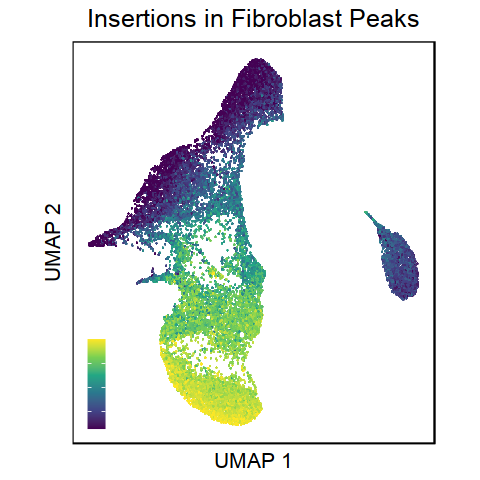

In [45]:
options(repr.plot.width = 4, repr.plot.height = 4)
fibr_frip

In [46]:
saveRDS(fibr_frip, file=sprintf("./Fig1/subfigs/%s_fibroblast_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [21]:
ggsave("tmp.png", fibr_frip, height=10, width=10)

### iPSC Peak Set

In [31]:
peak_intersect_ipsc = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))]
peak_intersect_ipsc

GRanges object with 140775 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 75764252-75764752      *
       [2]    chr17   1473114-1473614      *
       [3]    chr17 62423646-62424146      *
       [4]    chr17 72237150-72237650      *
       [5]    chr17 17891934-17892434      *
       ...      ...               ...    ...
  [140771]     chrY 16882468-16882968      *
  [140772]     chrY   4102088-4102588      *
  [140773]     chrY   5002700-5003200      *
  [140774]     chrY 18992665-18993165      *
  [140775]     chrY   5330031-5330531      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [32]:
# dividing by total insertions doesn't give a clean signal for iPSC peaks, D12/14 have overall low fraction of reads in peaks

# reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/metaData$total_insertions
reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/pmatRowSums

In [33]:
min(reads_in_ipsc_peaks)
median(reads_in_ipsc_peaks)
max(reads_in_ipsc_peaks)

[1] 0.2813064

[1] 0.6111573

[1] 0.910283

In [47]:
ipsc_frip = get_frip_plot_small(reads_in_ipsc_peaks, "Insertions in iPSC Peaks", peak_intersect_ipsc)

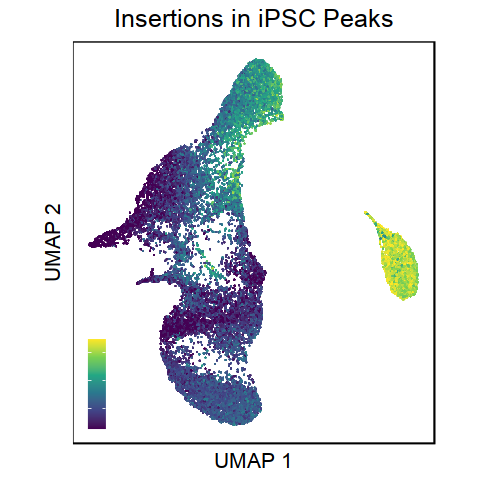

In [48]:
options(repr.plot.width = 4, repr.plot.height = 4)
ipsc_frip

In [49]:
saveRDS(ipsc_frip, file=sprintf("./Fig1/subfigs/%s_ipsc_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [220]:
ggsave("tmp.png", ipsc_frip, height=10, width=10)

## Fig 2

Using ChromVAR scores instead.

---

## Primed vs Naive

In [29]:
naive_gr = import("../../resources/GSE101074/naive.specific.atac.hg38.bed")
primed_gr = import("../../resources/GSE101074/primed.specific.atac.hg38.bed")

In [30]:
peak_intersect_naive = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, naive_gr)))]
peak_intersect_primed = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, primed_gr)))]
peak_intersect_naive

GRanges object with 3975 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr1     1585853-1587535      *
     [2]     chr1     1758673-1760121      *
     [3]     chr1     1906151-1907871      *
     [4]     chr1     2131382-2131898      *
     [5]     chr1     2566086-2566626      *
     ...      ...                 ...    ...
  [3971]     chrX 150032390-150033487      *
  [3972]     chrX 150751480-150752579      *
  [3973]     chrX 150968787-150969750      *
  [3974]     chrX 150972294-150973184      *
  [3975]     chrX 153682516-153683284      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [31]:
# reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/metaData$total_insertions
reads_in_naive_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, naive_gr)))])/pmatRowSums
reads_in_primed_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, primed_gr)))])/pmatRowSums

In [64]:
length(unique(queryHits(findOverlaps(peak_regions_gr, naive_gr))))
length(unique(queryHits(findOverlaps(peak_regions_gr, primed_gr))))

[1] 3975

[1] 1907

In [32]:
min(reads_in_naive_peaks)
median(reads_in_naive_peaks)
max(reads_in_naive_peaks)

min(reads_in_primed_peaks)
median(reads_in_primed_peaks)
max(reads_in_primed_peaks)

[1] 0

[1] 0.008708883

[1] 0.06345733

[1] 0

[1] 0.009635468

[1] 0.03575548

In [84]:
sum(reads_in_primed_peaks==0)

[1] 3

In [86]:
median(reads_in_naive_peaks/reads_in_primed_peaks)

[1] 0.9268293

In [33]:
naive_frip = get_frip_plot(reads_in_naive_peaks, "Insertions in Naive Specifc Peaks", peak_intersect_naive, upper_perc=.975)
primed_frip = get_frip_plot(reads_in_primed_peaks, "Insertions in Primed Specific Peaks", peak_intersect_primed, upper_perc=.975)

[1] -0.2732139

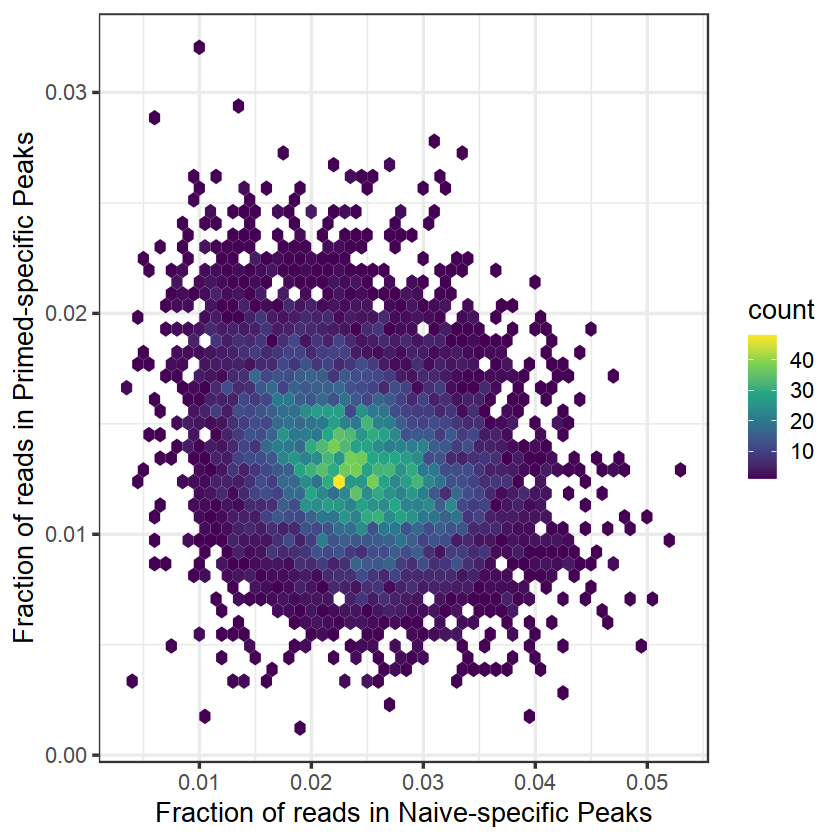

In [83]:
options(repr.plot.width = 7, repr.plot.height = 7)

cor(reads_in_naive_peaks[metaData$cluster==1],
    reads_in_primed_peaks[metaData$cluster==1])

ggplot(data.frame(x=reads_in_naive_peaks[metaData$cluster==1],
                 y=reads_in_primed_peaks[metaData$cluster==1]),
      aes(x=x,y=y)) +
geom_hex(bins=50) +
scale_fill_continuous(type = "viridis") +
theme_bw(base_size = 16) +
xlab("Fraction of reads in Naive-specific Peaks") +
ylab("Fraction of reads in Primed-specific Peaks")

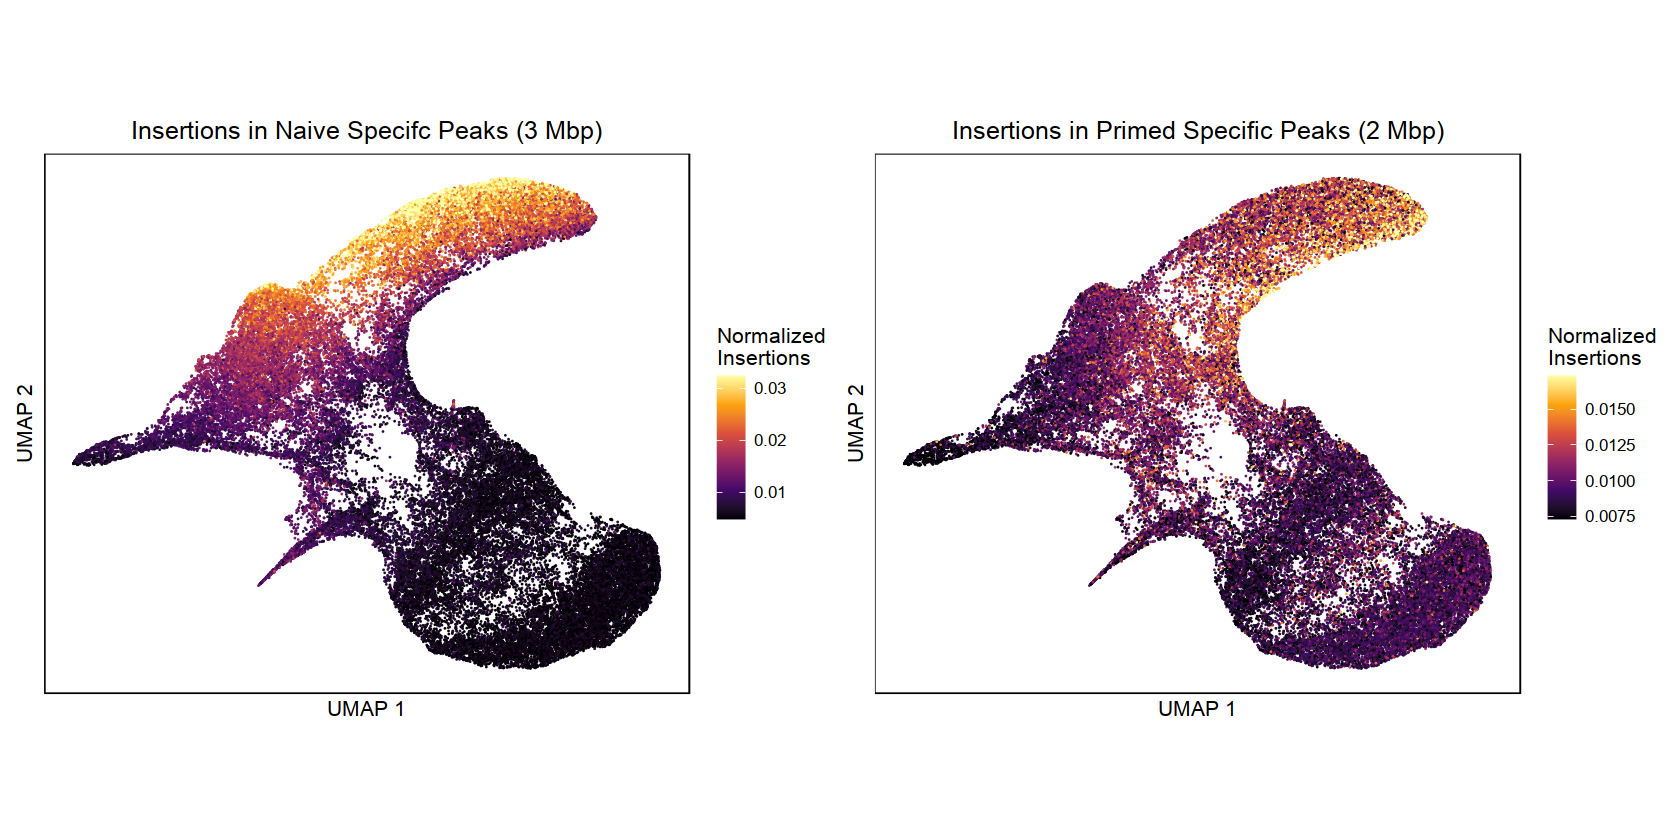

In [34]:
options(repr.plot.width = 14, repr.plot.height = 7)
naive_frip | primed_frip

In [50]:
saveRDS(KLF4_frip, file=sprintf("./Fig2/subfigs/%s_KLF4_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))